### Things to figure out:

1. How to save netCDF4 to GCS
2. How to transfer netCDF4 files to Zenodo

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import datetime
import numpy as np
from dateutil.relativedelta import * 
import json
import gcsfs

### References to Google Could Storage
- https://console.cloud.google.com/storage/browser/pangeo-hscannell
- https://gcsfs.readthedocs.io/en/latest/index.html
- https://github.com/pangeo-data/pangeo/issues/741

### Connect to Google Cloud Storage.

You will need to create a [service account](https://cloud.google.com/iam/docs/service-accounts) with appropriate permissions to read / write to your private bucket. 

Once you upload your service account key (json file) to your Pangeo Cloud home directory, you can use it as follows:

In [ ]:
# gcs = gcsfs.GCSFileSystem(anon=True)
# gcs.ls('pangeo-hscannell')
# file = gcs.open('pangeo-hscannell/OAFlux/lh_oaflux.nc')
# ds = xr.open_dataset(file)

In [ ]:
# with open('/home/jovyan/scannell-pangeo.json') as token_file:
#     token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token, access='read_write')

In [ ]:
# # List all directories
# gcs.ls('pangeo-hscannell')

In [ ]:
# Remove entire directories (Dangerous!)
# gcs.rm('pangeo-hscannell/*', recursive=True)

### Upload OAFlux 1º data products to GCS (https://oaflux.whoi.edu/data-access/)

Information about data is contained in the README (`/home/jovyan/marineHeatwave-image-classification/data/README_OAFlux_monthly.txt`)

In [ ]:
### This will download the OAFlux data from the FTP server (ftp://ftp.whoi.edu/pub/science/oaflux/data_v3/monthly/)
# ! chmod a+x download_data.sh
# ! ~./download_data.sh

In [2]:
var_name = ('evapr_oaflux', # monthly-mean ocean evaporation (cm/year)
            'lh_oaflux',    # latent heat flux (positive upward) (W/m2)
            'lw_isccp',     # net longwave radiation (positive upward) (W/m2)
            'qa_oaflux',    # 2m air humidity (g/kg)
            'qnet',         # net heat flux (positive downward) (W/m2)
            'sh_oaflux',    # sensible heat flux (positive upward) (W/m2)
            'sw_isccp',     # net shortwave radiation (positive downward) (W/m2)
            'ta_oaflux',    # 2m air temperature (degree-C)
            'ts_oaflux',    # sea surface temperature (degree-C)
            'ws_oaflux',    # 10m neutral wind speed (m/s)
           )

# All files for each variable include also the monthly-mean error estimates for 
# the corresponding variable.

# The flux and basic meteorological variables were saved by using "ncshort" format to 
# minimize the size of the file. Land and missing values are 32766. 
# ? All flux variables are multiplied by a factor of 10, 
# ? surface meterological variables by 100,
# ? evaporation by 10.


# Note, that the data off the WHOI FTP doesn't seem to be scaled.

scale_factor = [10,         # evapr_oaflux
                10,         # lh_oaflux
                10,         # lw_isccp
                1,          # qa_oaflux
                10,         # qnet
                10,         # sh_oaflux
                10,         # sw_isccp
                1,          # ta_oaflux
                1,          # ts_oaflux
                1]          # ws_oaflux

In [3]:
def read_netcdfs(files, dim, transform_func=None):
    '''Open all netcdf files, transform the time dimension, and concatentate the datasets along the time dimension'''
    def process_one_path(path):
        with xr.open_dataset(path) as ds:
            year = path[-7:-3]
            base = datetime.datetime(int(year), 
                                     1, 1)
            dates = np.array([base+relativedelta(months=+i) for i in ds.time.values-1])
            ds['time'] = dates
            ds = ds[list(ds.keys())[0]] 
            ds.load()
            return ds

    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim, )
    return combined


In [90]:
ds_dict = []
ds_attrs = []

for i in enumerate(var_name):
    print(i[1])
    da = read_netcdfs(f'/home/jovyan/marineHeatwave-image-classification/data/OAFlux/{i[1]}*.nc', dim='time')
    ds_attrs.append(da.attrs)
    da = da.where(da<32766, other=np.nan, drop=False)
#     da = da / scale_factor[i[0]]
    ds = da.to_dataset()
    ds_dict.append(ds)

ds_out = xr.merge(ds_dict)

for i in enumerate(ds_out.keys()):
    ds_out[i[1]].attrs = ds_attrs[i[0]]

evapr_oaflux
lh_oaflux
lw_isccp
qa_oaflux
qnet
sh_oaflux
sw_isccp
ta_oaflux
ts_oaflux
ws_oaflux


In [92]:
monthly_mean = ds_out.evapr.groupby(ds_out.time.dt.month).mean()

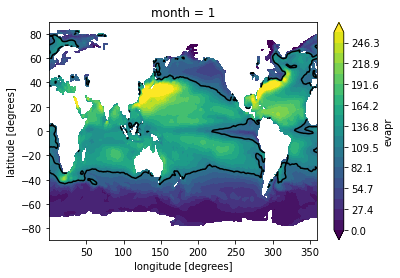

In [98]:
monthly_mean.sel(month=1).plot.contourf(levels=20, vmin=0, vmax=260, cmap=plt.get_cmap('viridis'))
monthly_mean.sel(month=1).plot.contour(levels=[100], colors='k')

In [95]:
# check size in MD 
ds_out.nbytes/1e9 

3.331246608

In [115]:
ds_out.lhtfl.attrs

{'comments': 'monthly mean surface latent heat flux, positive upward',
 'units': 'W/m^2'}

In [96]:
ds.to_netcdf(f'/home/jovyan/marineHeatwave-image-classification/data/OAFlux.nc')

In [113]:
ds.time.values

array(['1958-01-01T00:00:00.000000000', '1958-02-01T00:00:00.000000000',
       '1958-03-01T00:00:00.000000000', '1958-04-01T00:00:00.000000000',
       '1958-05-01T00:00:00.000000000', '1958-06-01T00:00:00.000000000',
       '1958-07-01T00:00:00.000000000', '1958-08-01T00:00:00.000000000',
       '1958-09-01T00:00:00.000000000', '1958-10-01T00:00:00.000000000',
       '1958-11-01T00:00:00.000000000', '1958-12-01T00:00:00.000000000',
       '1959-01-01T00:00:00.000000000', '1959-02-01T00:00:00.000000000',
       '1959-03-01T00:00:00.000000000', '1959-04-01T00:00:00.000000000',
       '1959-05-01T00:00:00.000000000', '1959-06-01T00:00:00.000000000',
       '1959-07-01T00:00:00.000000000', '1959-08-01T00:00:00.000000000',
       '1959-09-01T00:00:00.000000000', '1959-10-01T00:00:00.000000000',
       '1959-11-01T00:00:00.000000000', '1959-12-01T00:00:00.000000000',
       '1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', '1960-04-01

In [ ]:
# ds.to_zarr(gcs.get_mapper(f'gs://pangeo-hscannell/{i}'))

In [ ]:
# # List all directories
# gcs.ls('pangeo-hscannell/OAFlux')

```python
For files in path:
    make netcdf
    save locally
    put to GCS
    remove local file (os.remove?)
```

In [ ]:
# gcs.put('lh_oaflux.nc', f'gs://pangeo-hscannell/OAFlux/{i}.nc')

In [ ]:
# file = gcs.open('gs://pangeo-hscannell/OAFlux/lh_oaflux.nc') # Return a file-like object from the filesystem
# ds = xr.open_dataset(file)
# ds.nbytes/1e9 * 10

In [ ]:
# Get size of files
# gcs.du('pangeo-hscannell/OAFlux/lh_oaflux.nc') # compressed size in bytes on disk